### Sentiment Engine training

In [ ]:
!pip install transformers
from transformers import RobertaForSequenceClassification, RobertaTokenizer, BertForSequenceClassification, BertTokenizer, AutoModelForSequenceClassification, AutoTokenizer, AdamW

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/Projects/PLP_PracticeModule/

/content/drive/MyDrive/Projects/PLP_PracticeModule


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

In [70]:
df = pd.read_csv('small_dataset_for_training.csv',usecols=['body','entities','Stock'])
# df = df.loc[280001:360000].reset_index(drop=True)
df

,body,entities,Stock
0,$TSLA stock starting to rocket 🚀,Bullish,TSLA
1,$TSLA Money got banana it grow big \nBut took ...,Bullish,TSLA
2,"$AAPL bear logic last qtr, but the iPhone numb...",Bullish,AAPL
3,$AAPL 129 at the morning bell. Sleep well my B...,Bullish,AAPL
4,$AMZN $TSLA $AAPL $GOOGL now well get some che...,Bullish,TSLA
...,...,...,...
639995,$FB $280 puts\nburn it into soot\nwatch it tur...,Bearish,FB
639996,$AMZN pump...dump coming.,Bearish,AMZN
639997,$IWM Scary Money Is The Only Thing Holding Th...,Bearish,AAPL
639998,$FB Maybe you bulls could ask Brandon to pass ...,Bearish,FB


In [71]:
df['entities'] = df.entities.replace('Bullish',1).replace('Bearish',0)

In [ ]:
!pip install emoji

     |████████████████████████████████| 175 kB 7.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=a86ad02b479003ee7be39f1d744d981625f2728c3d6431603032074915b3a83d
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [72]:
import emoji
import re

def process_text(texts):
  # lowercase
  # message = message.lower() # RoBERTa tokenizer is uncased
  # remove URLs
  texts = re.sub(r'https?://\S+', "", texts)
  texts = re.sub(r'www.\S+', "", texts)
  # remove '
  texts = texts.replace('&#39;', "'")
  # remove symbol names
  texts = re.sub(r'(\#)(\S+)', r'hashtag_\2', texts)
  texts = re.sub(r'(\$)([A-Za-z]+)', r'cashtag_\2', texts)
  # remove usernames
  texts = re.sub(r'(\@)(\S+)', r'mention_\2', texts)
  # demojize
  texts = emoji.demojize(texts, delimiters=("", " "))


  return texts.strip()
    

In [73]:
df['body'] = df.body.apply(process_text)
df.head()

,body,entities,Stock
0,cashtag_TSLA stock starting to rocket rocket,1,TSLA
1,cashtag_TSLA Money got banana it grow big \nBu...,1,TSLA
2,"cashtag_AAPL bear logic last qtr, but the iPho...",1,AAPL
3,cashtag_AAPL 129 at the morning bell. Sleep we...,1,AAPL
4,cashtag_AMZN cashtag_TSLA cashtag_AAPL cashtag...,1,TSLA


In [74]:
labels = df.entities.values
text = df.body.values

In [75]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")

In [76]:
len(tokenizer)

50265

In [77]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [78]:
from nltk.tokenize import word_tokenize
def helper(text):
  t = word_tokenize(text)
  return len(t)
length = df.body.apply(helper)

In [79]:
print('there are {} entries in the dataframe'.format(len(length[length>=0])))
print('{}% of them have a length smaller than 32 tokens'.format(100-len(length[length>32])/32000))
print('{}% of them have a length smaller than 64 tokens'.format(100-len(length[length>64])/32000))
print('{}% of them have a length smaller than 128 tokens'.format(100-len(length[length>128])/32000))
print('So we just use 64 as RoBERTa tokenizer max padding length')

there are 640000 entries in the dataframe
97.0015% of them have a length smaller than 32 tokens
99.18453125% of them have a length smaller than 64 tokens
99.8300625% of them have a length smaller than 128 tokens
So we just use 64 as RoBERTa tokenizer max padding length


In [80]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    truncation=True,
    max_length=64,
    padding='max_length',
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

In [81]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [82]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.98*len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = val_size

train_dataset,val_dataset = random_split(dataset,[train_size,2*val_size])
# val_dataset, test_dataset = random_split(val_dataset,[val_size,test_size])
print('Training Size - ',train_size)
print('Validation Size - ',val_size*2)
# print('Test Size - ',test_size)

Training Size -  627200
Validation Size -  12800


#### continue

In [83]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 32)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 32)
# test_dl = DataLoader(test_dataset,sampler = SequentialSampler(test_dataset),
#                      batch_size = 32)
len(train_dl),len(val_dl)#,len(test_dl)

(19600, 400)

In [84]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
# model = BertForSequenceClassification.from_pretrained('bert-base-cased')
# model = AutoModelForSequenceClassification.from_pretrained("fineTuneFinBERT/")
# model = BertForSequenceClassification.from_pretrained('fineTuneFinBERT2/')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [86]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8,no_deprecation_warning=True)

In [87]:
from transformers import get_linear_schedule_with_warmup
epochs = 1
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [88]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [89]:
from sklearn.metrics import classification_report
def report(preds,labels):
  target_names = ['Bearish','Bullish']
  pred_flat = np.argmax(preds,axis=1).flatten()
  label_flat = labels.flatten()
  print(classification_report(label_flat,pred_flat,target_names=target_names,digits=4))

In [90]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [91]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dl)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation Accuracy: {val_acc}')
    report(predictions,true_vals)    

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/19600 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.39580057569836474
Validation loss: 0.34102927105501296
Validation Accuracy: 0.846484375
              precision    recall  f1-score   support

     Bearish     0.8380    0.8540    0.8459      6316
     Bullish     0.8551    0.8391    0.8470      6484

    accuracy                         0.8465     12800
   macro avg     0.8465    0.8466    0.8465     12800
weighted avg     0.8466    0.8465    0.8465     12800



### Model selection results


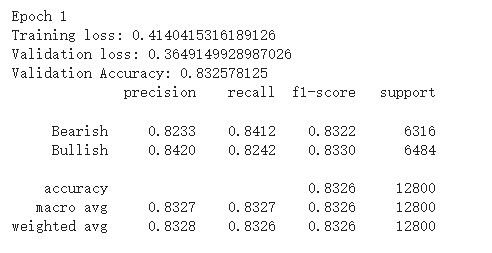
BERT-base

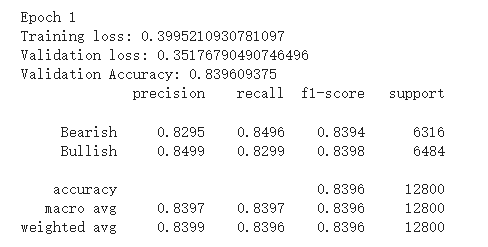
FinBERT1(ProsusAI/finbert)

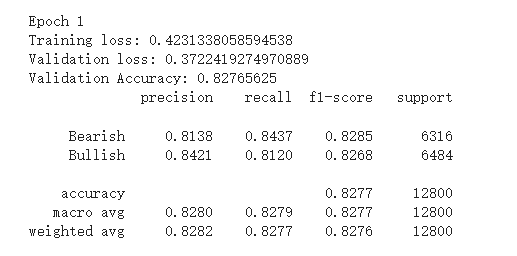
FinBERT2(yiyanghkust/finbert-tone)

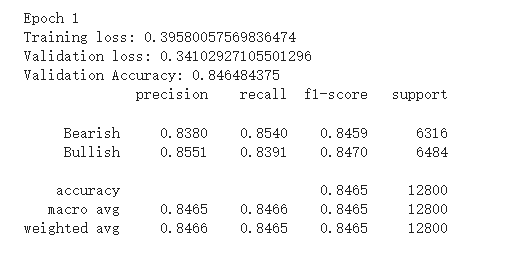
RoBERTa-base

### Hyper-parameters tuning results

#### lr=2e-5 batch_size=16

In [ ]:
Epoch 1
Training loss: 0.5042632510413726
Validation loss: 0.43245579536259177
Validation Accuracy: 0.79725
              precision    recall  f1-score   support

     Bearish     0.7693    0.8469    0.8062      3984
     Bullish     0.8312    0.7480    0.7874      4016

    accuracy                         0.7973      8000
   macro avg     0.8002    0.7974    0.7968      8000
weighted avg     0.8004    0.7973    0.7968      8000


Epoch 2
Training loss: 0.39124028661102056
Validation loss: 0.42084143990278244
Validation Accuracy: 0.812125
              precision    recall  f1-score   support

     Bearish     0.8190    0.7994    0.8091      3984
     Bullish     0.8056    0.8247    0.8151      4016

    accuracy                         0.8121      8000
   macro avg     0.8123    0.8121    0.8121      8000
weighted avg     0.8123    0.8121    0.8121      8000


Epoch 3
Training loss: 0.3177944357490374
Validation loss: 0.44553036565333604
Validation Accuracy: 0.819125
              precision    recall  f1-score   support

     Bearish     0.8020    0.8456    0.8232      3984
     Bullish     0.8381    0.7928    0.8148      4016

    accuracy                         0.8191      8000
   macro avg     0.8200    0.8192    0.8190      8000
weighted avg     0.8201    0.8191    0.8190      8000


Epoch 4
Training loss: 0.25728722433228457
Validation loss: 0.5336796762626618
Validation Accuracy: 0.819875
              precision    recall  f1-score   support

     Bearish     0.8096    0.8346    0.8219      3984
     Bullish     0.8307    0.8053    0.8178      4016

    accuracy                         0.8199      8000
   macro avg     0.8202    0.8199    0.8199      8000
weighted avg     0.8202    0.8199    0.8198      8000


Epoch 5
Training loss: 0.21827579473838624
Validation loss: 0.5881511765439064
Validation Accuracy: 0.819
              precision    recall  f1-score   support

     Bearish     0.8079    0.8351    0.8213      3984
     Bullish     0.8308    0.8030    0.8167      4016

    accuracy                         0.8190      8000
   macro avg     0.8193    0.8191    0.8190      8000
weighted avg     0.8194    0.8190    0.8190      8000

#### lr=2e-5 batch_size=32

In [ ]:
Epoch 1
Training loss: 0.5044473987221718
Validation loss: 0.4212539587020874
Validation Accuracy: 0.8015
              precision    recall  f1-score   support

     Bearish     0.7693    0.8589    0.8117      3984
     Bullish     0.8418    0.7445    0.7902      4016

    accuracy                         0.8015      8000
   macro avg     0.8056    0.8017    0.8009      8000
weighted avg     0.8057    0.8015    0.8009      8000


Epoch 2
Training loss: 0.39006926456424923
Validation loss: 0.41376688557863234
Validation Accuracy: 0.811375
              precision    recall  f1-score   support

     Bearish     0.8351    0.7741    0.8034      3984
     Bullish     0.7910    0.8484    0.8187      4016

    accuracy                         0.8114      8000
   macro avg     0.8131    0.8112    0.8111      8000
weighted avg     0.8130    0.8114    0.8111      8000


Epoch 3
Training loss: 0.3218885078231494
Validation loss: 0.42914476060867307
Validation Accuracy: 0.810625
              precision    recall  f1-score   support

     Bearish     0.8323    0.7761    0.8032      3984
     Bullish     0.7918    0.8449    0.8175      4016

    accuracy                         0.8106      8000
   macro avg     0.8121    0.8105    0.8104      8000
weighted avg     0.8120    0.8106    0.8104      8000


Epoch 4
Training loss: 0.26294659575323265
Validation loss: 0.4532522008121014
Validation Accuracy: 0.818375
              precision    recall  f1-score   support

     Bearish     0.8177    0.8175    0.8176      3984
     Bullish     0.8190    0.8192    0.8191      4016

    accuracy                         0.8184      8000
   macro avg     0.8184    0.8184    0.8184      8000
weighted avg     0.8184    0.8184    0.8184      8000

#### lr=2e-5 batch_size=64

In [ ]:
Epoch 1
Training loss: 0.5052129537264506
Validation loss: 0.46480056023597716
Validation Accuracy: 0.775875
              precision    recall  f1-score   support

     Bearish     0.7177    0.9066    0.8012      3984
     Bullish     0.8746    0.6462    0.7432      4016

    accuracy                         0.7759      8000
   macro avg     0.7961    0.7764    0.7722      8000
weighted avg     0.7965    0.7759    0.7721      8000


Epoch 2
Training loss: 0.39707499963707393
Validation loss: 0.40828417813777923
Validation Accuracy: 0.80625
              precision    recall  f1-score   support

     Bearish     0.7690    0.8732    0.8178      3984
     Bullish     0.8547    0.7398    0.7931      4016

    accuracy                         0.8062      8000
   macro avg     0.8119    0.8065    0.8055      8000
weighted avg     0.8120    0.8063    0.8054      8000


Epoch 3
Training loss: 0.33484467584557004
Validation loss: 0.4248538483381271
Validation Accuracy: 0.817875
              precision    recall  f1-score   support

     Bearish     0.7915    0.8612    0.8249      3984
     Bullish     0.8491    0.7749    0.8103      4016

    accuracy                         0.8179      8000
   macro avg     0.8203    0.8180    0.8176      8000
weighted avg     0.8204    0.8179    0.8176      8000


Epoch 4
Training loss: 0.2864336825410525
Validation loss: 0.43113778173923495
Validation Accuracy: 0.8175
              precision    recall  f1-score   support

     Bearish     0.8099    0.8278    0.8188      3984
     Bullish     0.8254    0.8073    0.8162      4016

    accuracy                         0.8175      8000
   macro avg     0.8176    0.8175    0.8175      8000
weighted avg     0.8177    0.8175    0.8175      8000

#### lr=2e-5 batch_size=128

In [ ]:
Epoch 1
Training loss: 0.514077968538125
Validation loss: 0.42559732662306893
Validation Accuracy: 0.797875
              precision    recall  f1-score   support

     Bearish     0.7726    0.8419    0.8058      3984
     Bullish     0.8278    0.7542    0.7893      4016

    accuracy                         0.7979      8000
   macro avg     0.8002    0.7981    0.7975      8000
weighted avg     0.8003    0.7979    0.7975      8000


Epoch 2
Training loss: 0.402296416818778
Validation loss: 0.4060899376396149
Validation Accuracy: 0.811875
              precision    recall  f1-score   support

     Bearish     0.7721    0.8828    0.8237      3984
     Bullish     0.8644    0.7415    0.7983      4016

    accuracy                         0.8119      8000
   macro avg     0.8183    0.8122    0.8110      8000
weighted avg     0.8185    0.8119    0.8110      8000


Epoch 3
Training loss: 0.3472650435423978
Validation loss: 0.4040014578236474
Validation Accuracy: 0.82
              precision    recall  f1-score   support

     Bearish     0.8045    0.8436    0.8236      3984
     Bullish     0.8370    0.7966    0.8163      4016

    accuracy                         0.8200      8000
   macro avg     0.8207    0.8201    0.8199      8000
weighted avg     0.8208    0.8200    0.8199      8000


Epoch 4
Training loss: 0.30775327400881697
Validation loss: 0.41464819439819883
Validation Accuracy: 0.81775
              precision    recall  f1-score   support

     Bearish     0.8151    0.8200    0.8176      3984
     Bullish     0.8204    0.8155    0.8179      4016

    accuracy                         0.8178      8000
   macro avg     0.8178    0.8178    0.8177      8000
weighted avg     0.8178    0.8177    0.8178      8000

#### lr=3e-5 batch_size=16

In [ ]:
Epoch 1
Training loss: 0.5136530679315329
Validation loss: 0.44436713041365145
Validation Accuracy: 0.793625
              precision    recall  f1-score   support

     Bearish     0.7955    0.7882    0.7918      3984
     Bullish     0.7918    0.7991    0.7954      4016

    accuracy                         0.7936      8000
   macro avg     0.7937    0.7936    0.7936      8000
weighted avg     0.7936    0.7936    0.7936      8000


Epoch 2
Training loss: 0.3992733389188846
Validation loss: 0.4063637013733387
Validation Accuracy: 0.810375
              precision    recall  f1-score   support

     Bearish     0.8458    0.7573    0.7991      3984
     Bullish     0.7819    0.8630    0.8205      4016

    accuracy                         0.8104      8000
   macro avg     0.8138    0.8102    0.8098      8000
weighted avg     0.8137    0.8104    0.8098      8000


Epoch 3
Training loss: 0.32029531909732356
Validation loss: 0.4651685864254832
Validation Accuracy: 0.813
              precision    recall  f1-score   support

     Bearish     0.8456    0.7641    0.8027      3984
     Bullish     0.7864    0.8616    0.8222      4016

    accuracy                         0.8130      8000
   macro avg     0.8160    0.8128    0.8125      8000
weighted avg     0.8158    0.8130    0.8125      8000

#### lr=3e-5 batch_size=32

In [ ]:
Epoch 1
Training loss: 0.507310801770952
Validation loss: 0.42496754831075667
Validation Accuracy: 0.79825
              precision    recall  f1-score   support

     Bearish     0.7703    0.8476    0.8071      3984
     Bullish     0.8321    0.7493    0.7885      4016

    accuracy                         0.7983      8000
   macro avg     0.8012    0.7984    0.7978      8000
weighted avg     0.8013    0.7983    0.7978      8000


Epoch 2
Training loss: 0.388926143805186
Validation loss: 0.39903738075494766
Validation Accuracy: 0.806875
              precision    recall  f1-score   support

     Bearish     0.8513    0.7417    0.7928      3984
     Bullish     0.7728    0.8715    0.8192      4016

    accuracy                         0.8069      8000
   macro avg     0.8121    0.8066    0.8060      8000
weighted avg     0.8119    0.8069    0.8060      8000


Epoch 3
Training loss: 0.3100626676413748
Validation loss: 0.44669066816568376
Validation Accuracy: 0.819375
              precision    recall  f1-score   support

     Bearish     0.8203    0.8160    0.8182      3984
     Bullish     0.8184    0.8227    0.8206      4016

    accuracy                         0.8194      8000
   macro avg     0.8194    0.8194    0.8194      8000
weighted avg     0.8194    0.8194    0.8194      8000

#### lr=3e-5 batch_size=64

In [ ]:
Epoch 1
Training loss: 0.502998171461953
Validation loss: 0.4538692235946655
Validation Accuracy: 0.776125
              precision    recall  f1-score   support

     Bearish     0.7182    0.9059    0.8012      3984
     Bullish     0.8739    0.6474    0.7438      4016

    accuracy                         0.7761      8000
   macro avg     0.7961    0.7766    0.7725      8000
weighted avg     0.7964    0.7761    0.7724      8000


Epoch 2
Training loss: 0.38839434218406677
Validation loss: 0.41002321553230286
Validation Accuracy: 0.810125
              precision    recall  f1-score   support

     Bearish     0.7778    0.8662    0.8196      3984
     Bullish     0.8504    0.7545    0.7996      4016

    accuracy                         0.8101      8000
   macro avg     0.8141    0.8103    0.8096      8000
weighted avg     0.8142    0.8101    0.8096      8000


Epoch 3
Training loss: 0.3158661618497637
Validation loss: 0.41855282080173495
Validation Accuracy: 0.818
              precision    recall  f1-score   support

     Bearish     0.8004    0.8454    0.8223      3984
     Bullish     0.8376    0.7908    0.8135      4016

    accuracy                         0.8180      8000
   macro avg     0.8190    0.8181    0.8179      8000
weighted avg     0.8190    0.8180    0.8179      8000


Epoch 4
Training loss: 0.2527464228603575
Validation loss: 0.4377720236778259
Validation Accuracy: 0.820125
              precision    recall  f1-score   support

     Bearish     0.8109    0.8331    0.8218      3984
     Bullish     0.8298    0.8073    0.8184      4016

    accuracy                         0.8201      8000
   macro avg     0.8203    0.8202    0.8201      8000
weighted avg     0.8204    0.8201    0.8201      8000


Epoch 5
Training loss: 0.206118429094553
Validation loss: 0.5013618243932724
Validation Accuracy: 0.81675
              precision    recall  f1-score   support

     Bearish     0.8048    0.8343    0.8193      3984
     Bullish     0.8295    0.7993    0.8141      4016

    accuracy                         0.8167      8000
   macro avg     0.8171    0.8168    0.8167      8000
weighted avg     0.8172    0.8167    0.8167      8000

#### lr=3e-5 batch_size=128

In [ ]:
Epoch 1
Training loss: 0.5106104534006881
Validation loss: 0.4116360398512038
Validation Accuracy: 0.802125
              precision    recall  f1-score   support

     Bearish     0.7747    0.8499    0.8105      3984
     Bullish     0.8352    0.7547    0.7929      4016

    accuracy                         0.8021      8000
   macro avg     0.8049    0.8023    0.8017      8000
weighted avg     0.8051    0.8021    0.8017      8000


Epoch 2
Training loss: 0.3930181047844421
Validation loss: 0.38866985364565776
Validation Accuracy: 0.81925
              precision    recall  f1-score   support

     Bearish     0.8129    0.8276    0.8201      3984
     Bullish     0.8258    0.8110    0.8183      4016

    accuracy                         0.8193      8000
   macro avg     0.8193    0.8193    0.8192      8000
weighted avg     0.8194    0.8193    0.8192      8000


Epoch 3
Training loss: 0.32967852082493887
Validation loss: 0.4115184074829495
Validation Accuracy: 0.81475
              precision    recall  f1-score   support

     Bearish     0.7814    0.8720    0.8242      3984
     Bullish     0.8565    0.7580    0.8042      4016

    accuracy                         0.8148      8000
   macro avg     0.8189    0.8150    0.8142      8000
weighted avg     0.8191    0.8147    0.8142      8000


#### lr=5e-5 batch_size=16

In [ ]:
Epoch 1
Training loss: 0.5974965874685182
Validation loss: 0.5948965945839881
Validation Accuracy: 0.7175
              precision    recall  f1-score   support

     Bearish     0.6671    0.8640    0.7528      3984
     Bullish     0.8092    0.5722    0.6704      4016

    accuracy                         0.7175      8000
   macro avg     0.7381    0.7181    0.7116      8000
weighted avg     0.7384    0.7175    0.7114      8000


Epoch 2
Training loss: 0.5715263673928049
Validation loss: 0.5630566267967224
Validation Accuracy: 0.73625
              precision    recall  f1-score   support

     Bearish     0.7603    0.6870    0.7218      3984
     Bullish     0.7166    0.7851    0.7493      4016

    accuracy                         0.7362      8000
   macro avg     0.7384    0.7361    0.7355      8000
weighted avg     0.7383    0.7362    0.7356      8000


Epoch 3
Training loss: 0.5522838095095423
Validation loss: 0.558704370379448
Validation Accuracy: 0.751125
              precision    recall  f1-score   support

     Bearish     0.7039    0.8635    0.7756      3984
     Bullish     0.8252    0.6397    0.7207      4016

    accuracy                         0.7511      8000
   macro avg     0.7646    0.7516    0.7481      8000
weighted avg     0.7648    0.7511    0.7480      8000


Epoch 4
Training loss: 0.47912135954863494
Validation loss: 0.47688990265131
Validation Accuracy: 0.778
              precision    recall  f1-score   support

     Bearish     0.8003    0.7385    0.7681      3984
     Bullish     0.7590    0.8172    0.7871      4016

    accuracy                         0.7780      8000
   macro avg     0.7797    0.7778    0.7776      8000
weighted avg     0.7796    0.7780    0.7776      8000


Epoch 5
Training loss: 0.4173517644057671
Validation loss: 0.4699419744759798
Validation Accuracy: 0.784125
              precision    recall  f1-score   support

     Bearish     0.7596    0.8288    0.7927      3984
     Bullish     0.8133    0.7398    0.7748      4016

    accuracy                         0.7841      8000
   macro avg     0.7865    0.7843    0.7838      8000
weighted avg     0.7866    0.7841    0.7837      8000

#### lr=5e-5 batch_size=32

In [ ]:
Epoch 1
Training loss: 0.5606839387284385
Validation loss: 0.46764432018995283
Validation Accuracy: 0.773125
              precision    recall  f1-score   support

     Bearish     0.7516    0.8133    0.7812      3984
     Bullish     0.7983    0.7333    0.7644      4016

    accuracy                         0.7731      8000
   macro avg     0.7749    0.7733    0.7728      8000
weighted avg     0.7750    0.7731    0.7728      8000


Epoch 2
Training loss: 0.4468867841296726
Validation loss: 0.4518423317670822
Validation Accuracy: 0.7875
              precision    recall  f1-score   support

     Bearish     0.7485    0.8635    0.8019      3984
     Bullish     0.8402    0.7122    0.7709      4016

    accuracy                         0.7875      8000
   macro avg     0.7943    0.7878    0.7864      8000
weighted avg     0.7945    0.7875    0.7863      8000


Epoch 3
Training loss: 0.366314064833853
Validation loss: 0.461272368222475
Validation Accuracy: 0.80475
              precision    recall  f1-score   support

     Bearish     0.7905    0.8271    0.8084      3984
     Bullish     0.8202    0.7826    0.8010      4016

    accuracy                         0.8047      8000
   macro avg     0.8054    0.8048    0.8047      8000
weighted avg     0.8054    0.8047    0.8047      8000


Epoch 4
Training loss: 0.2908383213215404
Validation loss: 0.4606119799315929
Validation Accuracy: 0.811625
              precision    recall  f1-score   support

     Bearish     0.8016    0.8263    0.8137      3984
     Bullish     0.8222    0.7971    0.8095      4016

    accuracy                         0.8116      8000
   macro avg     0.8119    0.8117    0.8116      8000
weighted avg     0.8119    0.8116    0.8116      8000

#### lr=5e-5 batch_size=64

In [ ]:
Epoch 1
Training loss: 0.518081511206097
Validation loss: 0.4243671133518219
Validation Accuracy: 0.795875
              precision    recall  f1-score   support

     Bearish     0.8080    0.7741    0.7907      3984
     Bullish     0.7848    0.8175    0.8008      4016

    accuracy                         0.7959      8000
   macro avg     0.7964    0.7958    0.7957      8000
weighted avg     0.7964    0.7959    0.7958      8000


Epoch 2
Training loss: 0.39756798548168604
Validation loss: 0.4209494873285294
Validation Accuracy: 0.812875
              precision    recall  f1-score   support

     Bearish     0.8041    0.8253    0.8146      3984
     Bullish     0.8220    0.8005    0.8112      4016

    accuracy                         0.8129      8000
   macro avg     0.8131    0.8129    0.8129      8000
weighted avg     0.8131    0.8129    0.8129      8000


Epoch 3
Training loss: 0.3127424329916636
Validation loss: 0.41800892412662505
Validation Accuracy: 0.816625
              precision    recall  f1-score   support

     Bearish     0.8243    0.8030    0.8135      3984
     Bullish     0.8094    0.8302    0.8197      4016

    accuracy                         0.8166      8000
   macro avg     0.8168    0.8166    0.8166      8000
weighted avg     0.8168    0.8166    0.8166      8000


Epoch 4
Training loss: 0.23908037155204348
Validation loss: 0.47631121349334715
Validation Accuracy: 0.814125
              precision    recall  f1-score   support

     Bearish     0.8024    0.8316    0.8167      3984
     Bullish     0.8267    0.7968    0.8115      4016

    accuracy                         0.8141      8000
   macro avg     0.8145    0.8142    0.8141      8000
weighted avg     0.8146    0.8141    0.8141      8000

#### lr=5e-5 batch_size=128

In [ ]:
Epoch 1
Training loss: 0.5166689987504461
Validation loss: 0.4398356529455336
Validation Accuracy: 0.786125
              precision    recall  f1-score   support

     Bearish     0.7498    0.8562    0.7995      3984
     Bullish     0.8340    0.7166    0.7709      4016

    accuracy                         0.7861      8000
   macro avg     0.7919    0.7864    0.7852      8000
weighted avg     0.7921    0.7861    0.7851      8000


Epoch 2
Training loss: 0.3953092567238884
Validation loss: 0.4046871945971534
Validation Accuracy: 0.80475
              precision    recall  f1-score   support

     Bearish     0.7663    0.8747    0.8169      3984
     Bullish     0.8554    0.7353    0.7908      4016

    accuracy                         0.8047      8000
   macro avg     0.8109    0.8050    0.8039      8000
weighted avg     0.8110    0.8047    0.8038      8000


Epoch 3
Training loss: 0.3168490469773328
Validation loss: 0.4269323514567481
Validation Accuracy: 0.8165
              precision    recall  f1-score   support

     Bearish     0.7961    0.8489    0.8217      3984
     Bullish     0.8396    0.7844    0.8110      4016

    accuracy                         0.8165      8000
   macro avg     0.8178    0.8166    0.8163      8000
weighted avg     0.8179    0.8165    0.8163      8000


Epoch 4
Training loss: 0.253418497066303
Validation loss: 0.4435635743633149
Validation Accuracy: 0.81725
              precision    recall  f1-score   support

     Bearish     0.8127    0.8225    0.8176      3984
     Bullish     0.8218    0.8120    0.8169      4016

    accuracy                         0.8173      8000
   macro avg     0.8173    0.8173    0.8172      8000
weighted avg     0.8173    0.8173    0.8172      8000


Epoch 5
Training loss: 0.20182169682708556
Validation loss: 0.5088193267583847
Validation Accuracy: 0.819625
              precision    recall  f1-score   support

     Bearish     0.8110    0.8316    0.8212      3984
     Bullish     0.8286    0.8078    0.8181      4016

    accuracy                         0.8196      8000
   macro avg     0.8198    0.8197    0.8196      8000
weighted avg     0.8198    0.8196    0.8196      8000
